# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [84]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [85]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [86]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, argnum=0)(x, y), j(f, argnum=1)(x, y)]).T
    return J_f

Exemples d'usage :

In [87]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

l=grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))
l[0]


0.5403023058681398

In [88]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [89]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [90]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

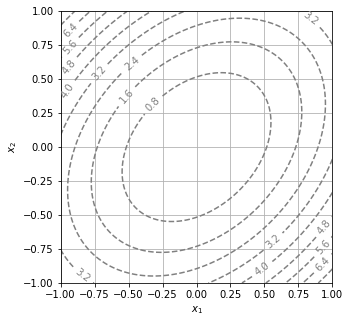

In [91]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [92]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

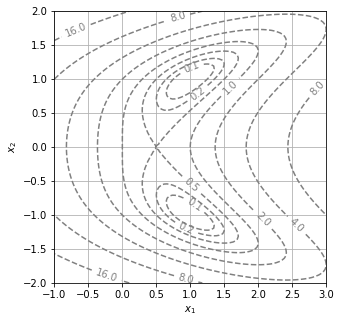

In [93]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [94]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

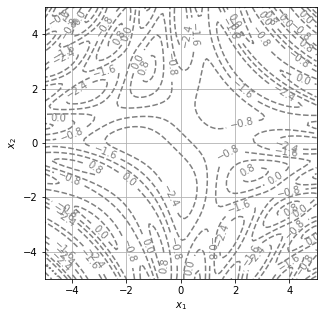

In [95]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [96]:
"""
Au vu de l'échelle et de l'épaisseur des traits sur les exemples, il est inutile d'atteindre une précision de 10**-4. 
On choisit eps = 10**-3 pour être certain de rester "dans l'épaisseur du trait"
"""
N = 100
epsi = 10**-2

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [97]:
#Xn+1 = Xn + f(xn)/f'(xn)

def Newton(f, x0, y0, eps=epsi, N=N):
    
    Jacques = J(f)
    for i in range(N):
        Jac = Jacques(x0,y0)
        x, y = x0 - np.linalg.lstsq(Jac, f(x0,y0))[0][0] , y0 - np.linalg.lstsq(Jac, f(x0,y0))[0][1] 
       
        if (x - x0)**2 + (y - y0)**2 <= eps**2 :
            return x, y
        x0,y0 = x,y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

c:\users\arthu\miniconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


0.4472137791286728 0.4472137791286728
[6.56970197e-07 0.00000000e+00]

 
 

liste des points : 
 [[0.53936021 0.2696801 ]
 [0.4472136  0.4472136 ]
 [0.34426519 0.51639779]
 [0.26971047 0.53942094]
 [0.21854345 0.54635864]
 [0.18260003 0.5478001 ]
 [0.15629294 0.54702531]
 [0.13640227 0.54560908]
 [0.12089387 0.54402243]
 [0.10846672 0.54233362]]


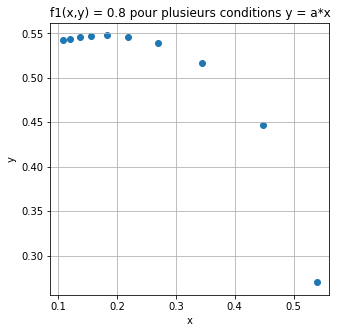

In [98]:
#Premier test : on vérifie qu'on obtient des valeurs cohérentes sur l'exemple suggéré.

def f10 (x,y):
        x = np.array(x)
        y = np.array(y)
        return np.array([f1(x,y) -0.8, x - y])  #condition x=y
    
(x,y)=Newton(f10,1.0,1.0)
print(x,y)                  #cohérent avec les courbes données au-dessus
print(f10(x,y))             #on vérifie que la fonction est bien nulle pour le point trouvé
print('\n \n \n')

#On cherche les points vérifiant a*x = y et f(x,y) = 0 pour plusieurs a, en partant de valeurs aléatoires entre 0 et 1 pour 
#x0 et y0.


points = np.empty((10,2))
for i in range (1,11) :   #10 différents tests en tout
    def f1_test(x, y) :   #on définit la fonction qui traduit la condition
        x = np.array(x)
        y = np.array(y)
        return np.array([f1(x,y) -0.8, 0.5*i*x - y])
        
    points[i-1] = Newton(f1_test,np.random.rand(),np.random.rand()) #on place le résultat dans la liste


print('liste des points : \n',points) #on peut vérifier 
plt.scatter(points[:,0],points[:,1]) #on trace les points sur un graphique
plt.xlabel('x')
plt.ylabel('y')
plt.title('f1(x,y) = 0.8 pour plusieurs conditions y = a*x')
plt.grid()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

300


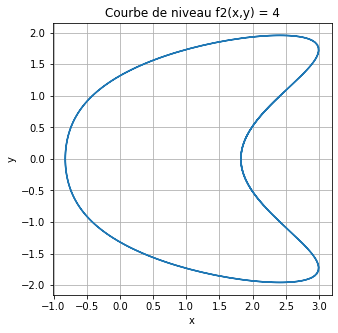

In [99]:
def level_curve(f, niv, x0, y0, delta=0.1, N=1000, eps=0.01):
    R = np.empty((N,2)) #liste des points
    grad_f = grad(f)
    for i in range (0,N) :
        g1,g2 = grad_f(x0,y0)
        #On se déplace d'un vecteur unitaire vers la droite : dans la direction de (g2,-g1)
        x,y = x0 + delta * g2 / np.sqrt(g1**2 + g2**2), y0 + delta * (-g1) / np.sqrt(g1**2 + g2**2)
        
        def fi(a,b): #On définit une nouvelle condition à chaque boucle : respecter la distance au point précédent
            return(np.array([f(a,b) - niv, np.sqrt((a-x0)**2 + (b-y0)**2) -delta]))
        (x0,y0) = Newton(fi,x,y,epsi)
        R[i] = [x0,y0]
        
    return R


#On teste le programme sur la fonction f2 :

points = level_curve(f2, 4, 2.5, 1.,N=300) 
plt.plot(points[:,0],points[:,1])
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Courbe de niveau f2(x,y) = 4')
print(len(points))
    

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

c:\users\arthu\miniconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


116


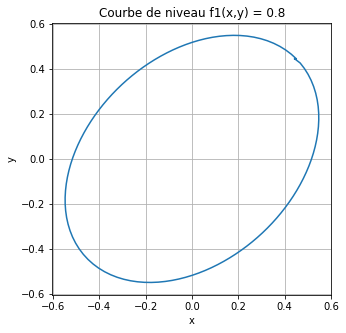

In [100]:
def new_level_curve(f, c, x0, y0, delta=0.05, epsi=epsi):
    R = []
    grad_f = grad(f)
    
    ### Calcul du premier point
    g1,g2 = grad_f(x0,y0)
    x,y = x0 + delta * g2 / np.sqrt(g1**2 + g2**2), y0 + delta * (-g1) / np.sqrt(g1**2 + g2**2)
    def fi(a,b):
        return(np.array([f(a,b) - c, np.sqrt((a-x0)**2 + (b-y0)**2) -delta]))
    (x0,y0) = Newton(fi,x,y,epsi,5000)
    R.append([x0,y0])
    
    xi, yi = x0, y0 #coordonnées initiales
    
    ### Calcul du deuxième point
    
    g1,g2 = grad_f(x0,y0)
    x,y = x0 + delta * g2 / np.sqrt(g1**2 + g2**2), y0 + delta * (-g1) / np.sqrt(g1**2 + g2**2)
    def fi(a,b):
        return(np.array([f(a,b) - c, np.sqrt((a-x0)**2 + (b-y0)**2) -delta]))
    (x0,y0) = Newton(fi,x,y,epsi)
    
    R.append([x0,y0])
    
    
    ### On peut donc implémenter notre fonction de la même manière que dans la fonction d'origine, mais avec une condition supplémentaire de bouclage
    
    i = 2
    while not np.sqrt((xi-x0)**2 + (yi-y0)**2) < delta - epsi :  # On s'arrête quand on tombe à une distance < (delta - incertitude) du point de départ  
        x_avant, y_avant = x0, y0
        g1,g2 = grad_f(x0,y0)
        x,y = x0 + delta * g2 / np.sqrt(g1**2 + g2**2), y0 + delta * (-g1) / np.sqrt(g1**2 + g2**2)
        def fi(a,b):
            return(np.array([f(a,b) -c, np.sqrt((a-x0)**2 + (b-y0)**2) -delta]))
        (x0,y0) = Newton(fi,x,y,epsi)
        
        R.append([x0,y0])
        i+=1
    R.append([xi,yi]) 
    return np.array(R)

points = new_level_curve(f1, 0.8, 0.4, 0.4,delta = 0.03) 
plt.plot(points[:,0],points[:,1])
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Courbe de niveau f1(x,y) = 0.8')
print(len(points))

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

c:\users\arthu\miniconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


0.8888


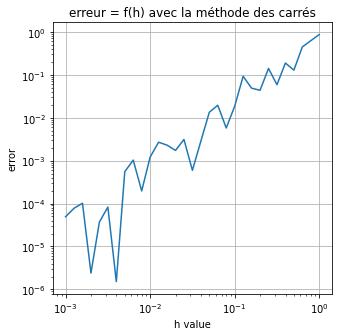

In [101]:
def area_squares(f,c,h, x0, y0):
    # On commence par chercher le côté "a" du quadrillage, ce qui nous donne un nombre "n" de carrés:
    points = new_level_curve(f,c,x0,y0) 
    x1_min = np.min(points[:,0])
    x1_max = np.max(points[:,0])
    x2_min = np.min(points[:,1])
    x2_max = np.max(points[:,1])
    a = max(x1_max - x1_min, x2_max - x2_min)
    n = round(a/h)
    
    # On calcule alors les coordonnées des centres
    res = np.empty((n,n,2))
    ind_l, ind_c = np.indices((n,n))
    res[:,:,0] = ind_l
    res[:,:,1] = ind_c
    centers = h*res + np.array([x1_min,x2_min]) + h/2    #tableau des centres des carrés
    #plt.plot(points[:,0],points[:,1])
    #plt.scatter(centers[...,0],centers[...,1])
    #plt.show()
    
    # On compte les centres qui vérifient f(x1,x2)<=c et on multiplie par l'aire du petit carré :
    f_centers = f(centers[...,0], centers[...,1])  # tableau des f(centre)
    area = np.sum(f_centers <= c) * h**2
    return(area)

###Test
aire_f1_carré = area_squares(f1,0.8,0.01,0.4,0.4)
print(aire_f1_carré)

# Application au disque unité
def f(x,y):
    return x**2 + y**2 

area_squares(f,1,0.01,0.,1.)

les_h = [10**(-i/10) for i in range(31)]
deltas_area = [abs(area_squares(f,1,h,0.,1.) - np.pi) for h in les_h]
plt.xlabel("h value")
plt.ylabel("error")
plt.title('erreur = f(h) avec la méthode des carrés')
plt.loglog(les_h, deltas_area)
plt.grid()

#Lorsque l'érreur devient trop petite, python utilise des approximations ce qui explique l'allure de la courbe pour les petites
#valeurs de h. Cependant, on constate que l'allure de la courbe est cohérent : l'erreur diminue comme le carré de h 
#(coefficient directeur de 2)


**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [102]:
#On surestime l'aire en comptant les carrés qui ont au moins un coin dans le domaine.
#On la sousestime en comptant les carrés qui ont tous les coins dans le domaine.


def area_squares_encadrement(f,c,h, x0, y0):  #renvoie ((aire sousestimée, aire surestimée), erreur)

    
    # On commence par chercher le côté "a" du quadrillage, ce qui nous donne un nombre "n" de carrés:
    points = new_level_curve(f,c,x0,y0) 
    x1_min = np.min(points[:,0])
    x1_max = np.max(points[:,0])
    x2_min = np.min(points[:,1])
    x2_max = np.max(points[:,1])
    a = max(x1_max - x1_min, x2_max - x2_min)
    n = round(a/h)
    
    # On calcule alors les coordonnées des centres
    res = np.empty((n,n,2))
    ind_l, ind_c = np.indices((n,n))
    res[:,:,0] = ind_l
    res[:,:,1] = ind_c
    centers = h*res + np.array([x1_min,x2_min]) + h/2    #tableau des centres des carrés
    
    # On compte les centres qui vérifient f(x1,x2)<=c et on multiplie par l'aire du petit carré :
    
    nb_centers_under = np.sum((f(centers[...,0] + h/2, centers[...,1] + h/2) <= c)
                              & (f(centers[...,0] - h/2, centers[...,1] - h/2) <= c) 
                                & (f(centers[...,0] + h/2, centers[...,1] - h/2) <= c)
                                & (f(centers[...,0] - h/2, centers[...,1] + h/2) <= c))
    
    nb_centers_over = np.sum((f(centers[...,0] + h/2, centers[...,1] + h/2) <= c) 
                              | (f(centers[...,0] - h/2, centers[...,1] - h/2) <= c) 
                                | (f(centers[...,0] + h/2, centers[...,1] - h/2) <= c)
                                | (f(centers[...,0] - h/2, centers[...,1] + h/2) <= c))
    
    area = h**2 * nb_centers_under, h**2 * nb_centers_over
    e = area[1] - area[0] 
    return(area,e) #renvoie ((aire sousestimée, aire surestimée), erreur)


#Test : on peut encadrer l'aire du disque unité à 10**-2 près à l'aide d'une boucle
h = 0.1
e = 1
while e > 10**(-2) : 
    aire_carré_f = area_squares_encadrement(f,1,h,0.,1.)
    e = aire_carré_f[1]
    h = h / 2

print(aire_carré_f) #on obtient une précision de 6*10**(-3)


((3.1384619140625007, 3.144678955078126), 0.0062170410156250355)


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

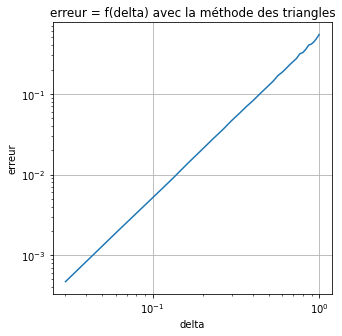

In [103]:
#L'aire d'un triangle est la moitiéde la  norme du produit vectoriel de 2 côtés.
#La 3è coordonnée du produit vectoriel dans le plan est sa norme affectée du signe correspondant au sens de rotation.

def aire_triangles(points):
    #On place le point proche du domaine étudié :
    x_min = np.min(points[:,0])
    x_max = np.max(points[:,0])
    y_min = np.min(points[:,1])
    y_max = np.max(points[:,1])
    p = [np.random.choice(np.arange(x_min,x_max,(x_max-x_min)/10)),np.random.choice(np.arange(y_min,y_max,(y_max-y_min)/10))]
    #Le point a tout de même des chances d'être hors de la courbe, car on s'est placé dans un rectangle
    
    n = len(points)
    aire = 0
    for i in range(n-1) :
        a = np.array([points[i,0]-p[0],points[i,1]-p[1],0])
        b = np.array([points[i+1,0]-p[0],points[i+1,1]-p[1],0])
        aire += np.cross(a,b)[2] #On est dans le plan et on tourne dans le sens horaire donc l'aire (x2) est l'opposé de la 
                                 #3è coordonnée
    return -aire/2 

#TEST!!!!!
D = np.linspace(0.03,1,30)
E = [abs(np.pi - aire_triangles(new_level_curve(f,1.,0.,1.,delta=d))) for d in D]

plt.xlabel('delta')
plt.ylabel('erreur')
plt.title('erreur = f(delta) avec la méthode des triangles')
plt.loglog(D,E)
plt.grid()

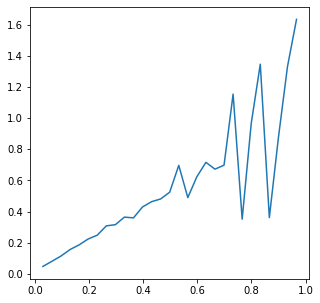

In [104]:
#On constate que l'erreur diminue comme le carré de delta
n = len(D)
deriv = [(E[i+1] - E[i])/(D[i+1] - D[i]) for i in range(n-1)]
plt.plot(D[:-1],deriv)

In [105]:
#f'(x) = x : l'erreur vaut (delta**2)/2 + cste

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [106]:
def aire_triangles_ext(points):
    x_min = np.min(points[:,0])
    x_max = np.max(points[:,0])
    y_min = np.min(points[:,1])
    y_max = np.max(points[:,1])
    p = [1,1]
    #Le point a des chances d'être hors de la courbe
    n = len(points)
    aire = 0
    for i in range(n-1) :
        a = np.array([points[i,0]-p[0],points[i,1]-p[1],0])
        b = np.array([points[i+1,0]-p[0],points[i+1,1]-p[1],0])
        aire += np.cross(a,b)[2]
    return -aire/2

print(aire_triangles_ext(points))

#Explications :

# c.f. scéma ci dessous

# l'aire des triangles de type P Z(i) Z(i+1) (vert) est comptée positivement car le produit vectoriel PZ(i)^PZ(i+1) est selon l'axe -z
# l'aire des triangles de type P Z(j) Z(j+1) (rouge) est comptée négativement car le produit vectoriel PZ(j)^PZ(j+1) est selon l'axe +z

# l'aire de la partie du triangle vert qui n'est pas à l'intérieur de (K) va donc être soustraite en ajoutant l'aire négative du triangle rouge.
# cette compensation permet de calculer l'aire même lorsque P est à l'extérieur de (K)

0.8880442300667509


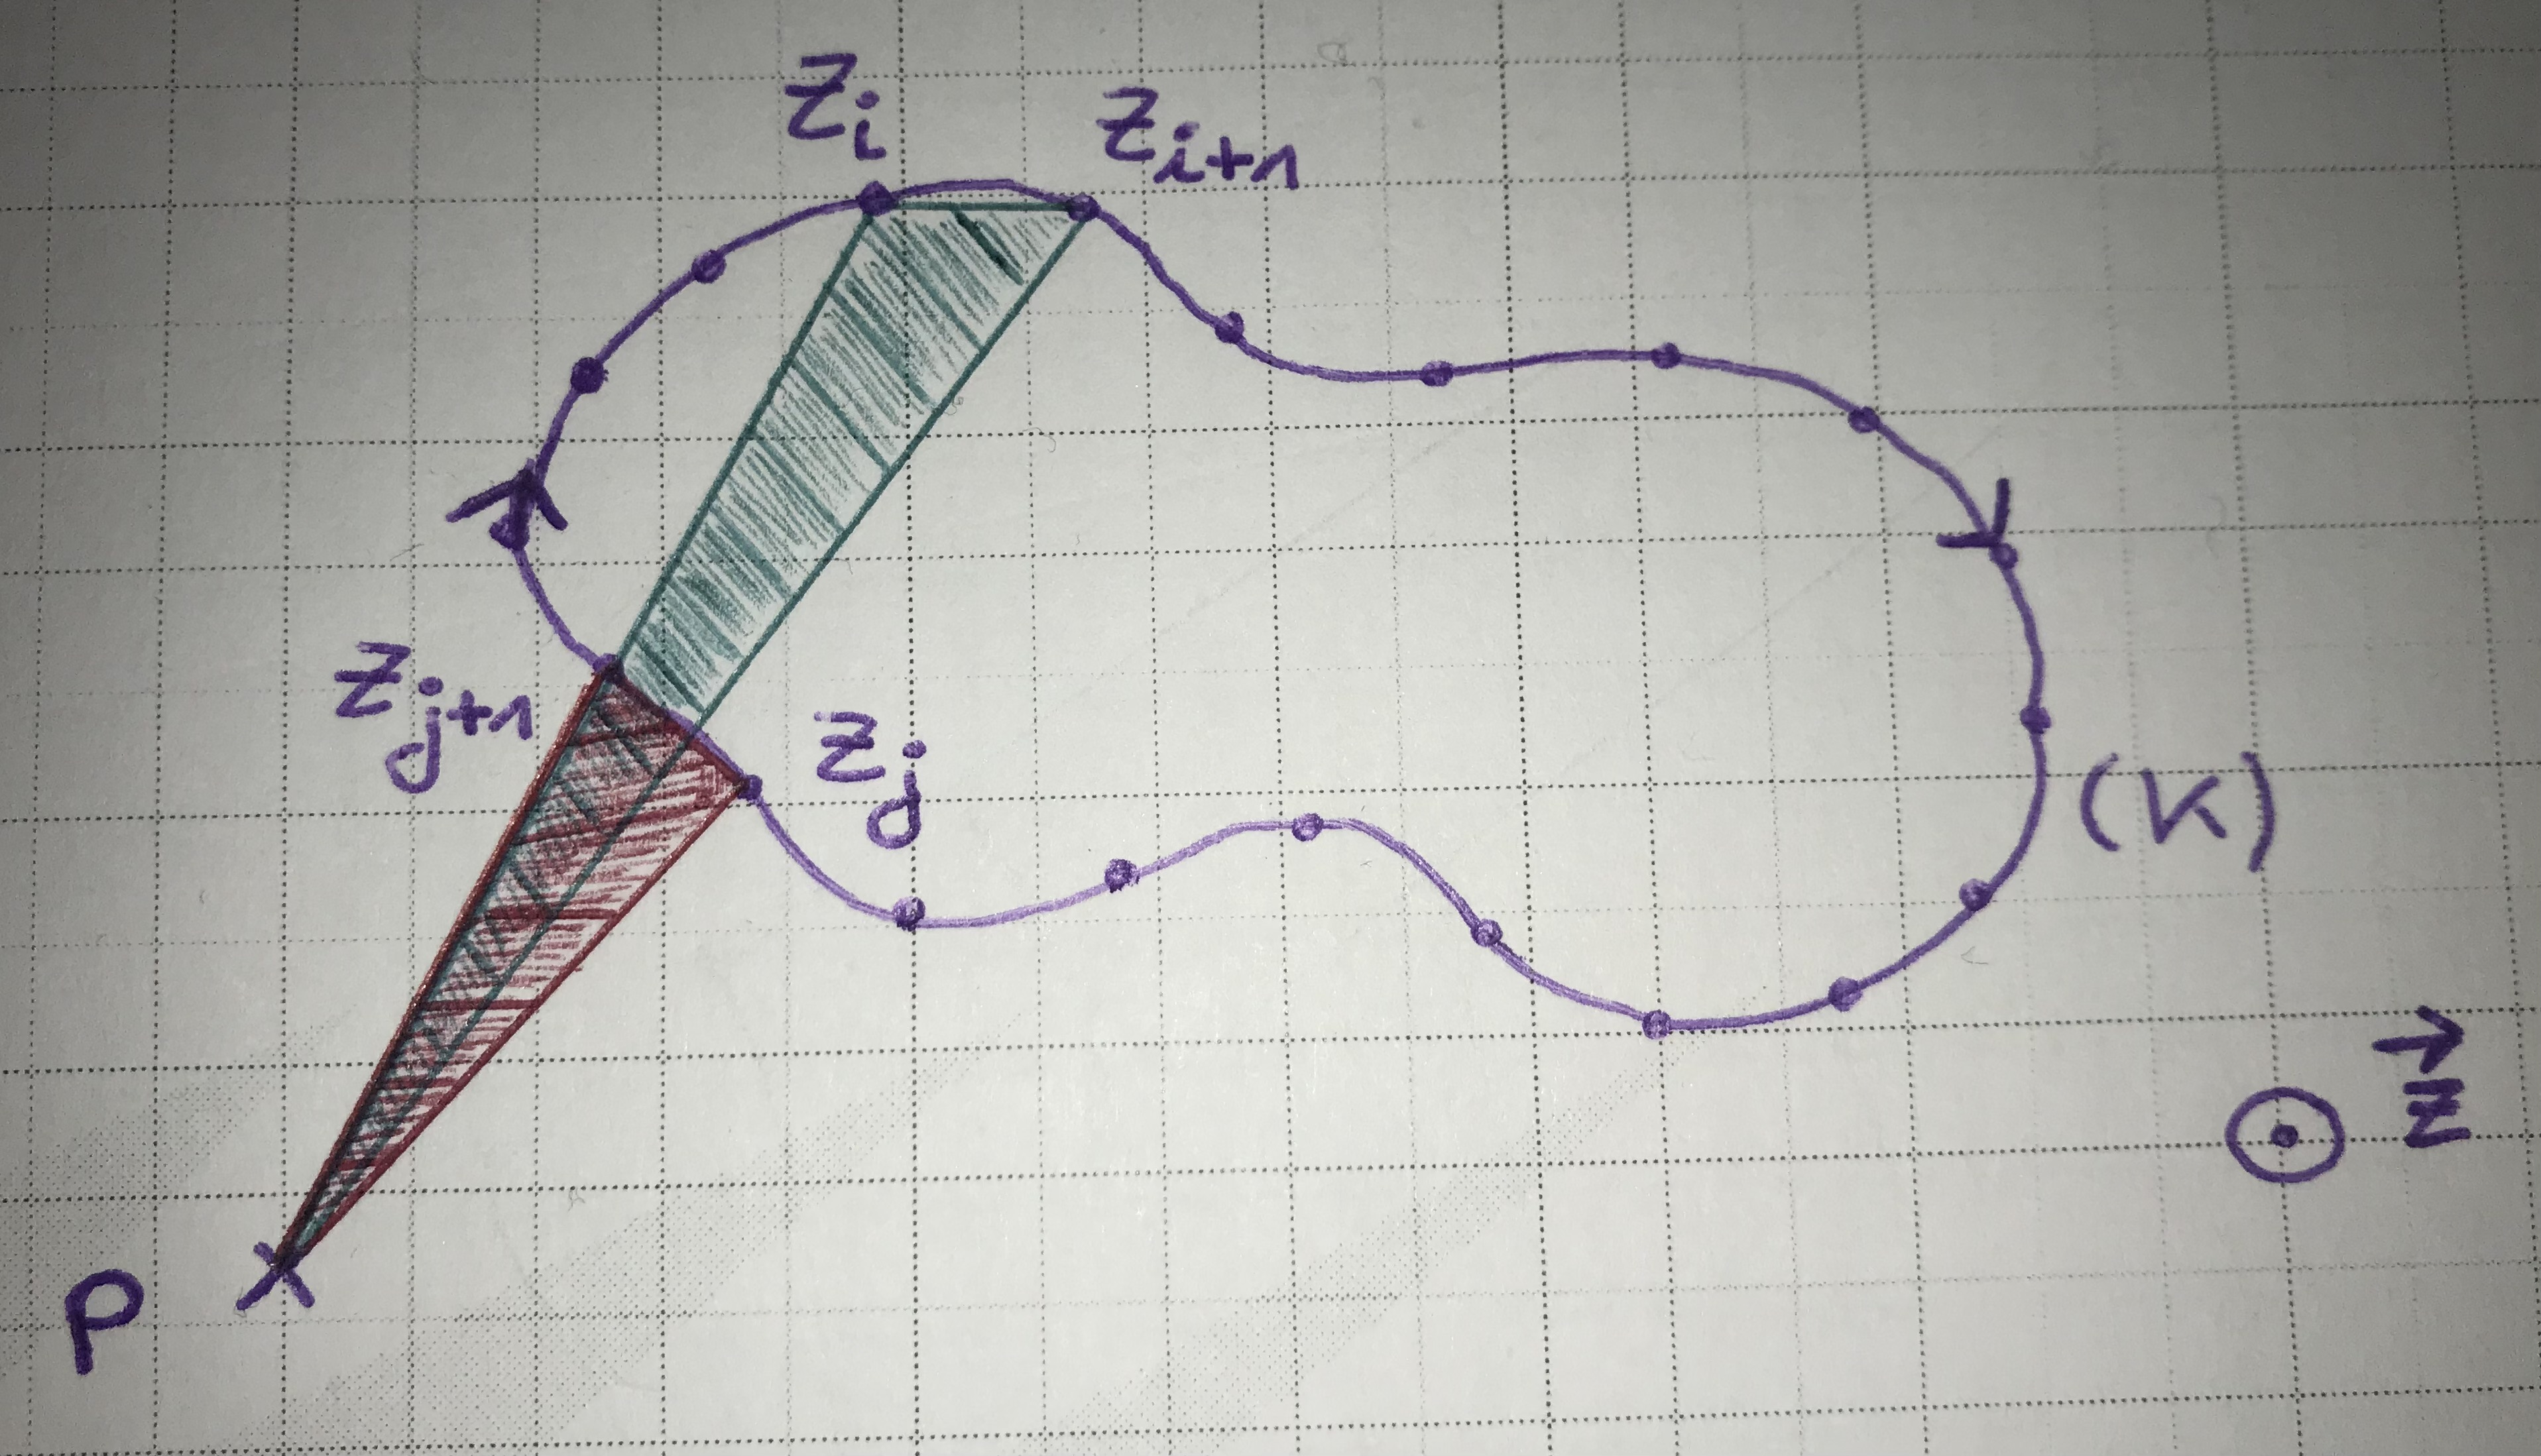

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [107]:
def f_cercle_1(x,y):
    return(x**2 + y**2)
def f_cercle_2(x,y):
    return((x-3)**2 + y**2)
# On génère les courbes de niveau (circulaires)
les_points = list(new_level_curve(f_cercle_1, 1, 1., 0.)) + list(new_level_curve(f_cercle_2, 1, 2., 0.))

# On ajoute le premier point à la fin pour boucler
les_points.append(les_points[0]) 

les_points = np.array(les_points) # L'argument requis est un tableau
print(aire_triangles(les_points))


c:\users\arthu\miniconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


6.280583270862811


In [108]:
# On obtient une valeur proche 2*pi, qui est la valeur attendue

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [109]:
def area_triangles(f,c,x0,y0):
    points=new_level_curve(f,c,x0,y0)
    return(aire_triangles(points))
print(area_triangles(f1,0.8,0.4,0.4))
    

0.8872218261339629


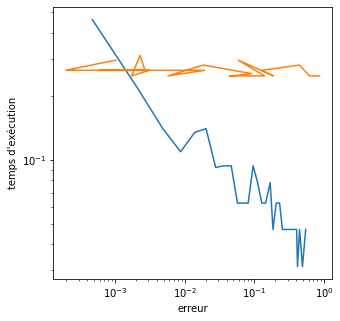

In [110]:
import time as t

D = np.linspace(0.03,1,30)
error_triangle = []
time_triangle = []
for d in D:
    t1 = t.time()
    area = aire_triangles(new_level_curve(f,1.,0.,1.,delta=d))
    t2 = t.time()
    time_triangle.append(t2 - t1)
    error_triangle.append(abs(np.pi - area))
    
les_h = [10**(-i/10) for i in range(23)]
error_square = []
time_square = []
for h in les_h : 
    t1 = t.time()
    area = area_squares(f,1,h,0.,1.)
    t2 = t.time()
    time_square.append(t2-t1)
    error_square.append(abs(np.pi - area))
    
plt.xlabel('erreur')
plt.ylabel("temps d'exécution")
plt.loglog(error_triangle,time_triangle)
plt.loglog(error_square,time_square)


In [111]:
""" 
Si on veut une précision moins bonne que 10**(-3), la méthode des triangles est plus efficace.
Cela s'explique par un appel à level_curve plus rapide que dans la méthode des carrés car la distance delta augmente. (C'est un choix, c.f. ci dessous)

La méthode des carrés devient plus efficace pour des précisions meilleures que 10**(-3),
son temps d'exécution est d'ailleurs quasi-constant quand delta est petit devant h.

Si on voulait des précisions encore meilleures, h deviendrait petit devant delta et le temps de la méthode des carrés ne serait plus constant.
"""

" \nSi on veut une précision moins bonne que 10**(-3), la méthode des triangles est plus efficace.\nCela s'explique par un appel à level_curve plus rapide que dans la méthode des carrés car la distance delta augmente. (C'est un choix, c.f. ci dessous)\n\nLa méthode des carrés devient plus efficace pour des précisions meilleures que 10**(-3),\nson temps d'exécution est d'ailleurs quasi-constant quand delta est petit devant h.\n\nSi on voulait des précisions encore meilleures, h deviendrait petit devant delta et le temps de la méthode des carrés ne serait plus constant.\n"

In [112]:
"""
Le tracé de la courbe de niveau est nécessaire à l'application des deux méthodes,
c'est pourquoi le temps de calcul de la courbe de niveau est pris en compte dans la comparaison.

On a (f,c) en argument de la méthode des carrés, mais des listes de points (x,y) pour les triangles.
Afin de comparer la même chose, on a donc effectué le choix de prendre (f,c) en argument de la méthode des triangles.

On pourrait refaire la comparaison en prenant (x,y) en argument des triangles et des carrés.

"""

"\nLe tracé de la courbe de niveau est nécessaire à l'application des deux méthodes,\nc'est pourquoi le temps de calcul de la courbe de niveau est pris en compte dans la comparaison.\n\nOn a (f,c) en argument de la méthode des carrés, mais des listes de points (x,y) pour les triangles.\nAfin de comparer la même chose, on a donc effectué le choix de prendre (f,c) en argument de la méthode des triangles.\n\nOn pourrait refaire la comparaison en prenant (x,y) en argument des triangles et des carrés.\n\n"